In [4]:
from tqdm import tqdm
from analysis.nlp_transformations import separate_previous_conversation, remove_footers
from typing import List
from dao.lab_report import DAOLabReport

from dao.attribute import DAOAttributePL

from models.attribute import AttributePL, AttributePLInDB

from ml.model_training import evaluate_models, k_fold_cross_validation
from ml.data_preparation import convert_db_attributes_to_input_data
from typing import List
from analysis.nlp_transformations import replace_links_with_text
from ml.data_preparation import find_significant_features

In [5]:
dao_attribute: DAOAttributePL = DAOAttributePL('attributes_reference', db_name="ananas_prod")


generated: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": True})
real: List[AttributePLInDB] = dao_attribute.find_many_by_query({"is_generated": False})

generated_flat_dict = [(x.to_flat_dict_normalized(), 1) for x in generated]
real_flat_dict = [(x.to_flat_dict_normalized(), 0) for x in real]

In [6]:
data = [(x.to_flat_dict_normalized(), 1) for x in generated]
data += [(x.to_flat_dict_normalized(), 0) for x in real]
# replace None with 0
for i in range(len(data)):
    for key in data[i][0].keys():
        if data[i][0][key] is None:
            data[i][0][key] = 0

significant_features = find_significant_features(data)

In [7]:
significant_features

['stylometrix_metrics.grammatical_forms.G_PRO_REL',
 'combination_features.common_long_word_ratio',
 'stylometrix_metrics.grammatical_forms.G_ADP',
 'combination_features.partial_attribute_statistics.perplexity_base.average',
 'combination_features.partial_attribute_statistics.perplexity_base_normalized.average',
 'combination_features.partial_attribute_statistics.perplexity.average',
 'stylometrix_metrics.inflection.IN_PRO_1NOM',
 'stylometrix_metrics.syntactic.SY_S_NOM',
 'stylometrix_metrics.lexical.L_CONT_A',
 'combination_features.common_rare_word_ratio',
 'stylometrix_metrics.lexical.L_TCCT1',
 'perplexity_base',
 'stylometrix_metrics.lexical.L_CONT_T',
 'combination_features.partial_attribute_statistics.number_of_errors.average',
 'number_of_errors',
 'stylometrix_metrics.inflection.IN_V_ACT',
 'combination_features.partial_attribute_statistics.standard_deviation_sentence_char_length.average',
 'combination_features.partial_attribute_statistics.variance_sentence_char_length.aver

In [8]:
from matplotlib import pyplot as plt
import numpy as np


def hist_attribute(data, title, num_bin = 21, max_value=5, min_value=0, metric_name="Metric", top=0.5, file_name=""):
    data_to_plot = []
    for d in data:
        if d<max_value:
            data_to_plot.append(d)
        else:
            data_to_plot.append(max_value)

    w = (max_value-min_value)/num_bin
    weights = np.ones_like(data_to_plot) / len(data_to_plot)
    plt.hist(data_to_plot, bins=np.arange(min_value, max_value + w, w), weights=weights)
    plt.title(title)
    plt.xlim([min_value, max_value])
    plt.ylim(top=top)
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Lab reports share')
    # plt.xticks([i for i in range(min_value, max_value+1, 2)])
    plt.savefig(f'../images/{file_name}.png')
    plt.show()

def plot_two_hists(data1, data2, title, metric_name="Metric", num_bin=21, min_value=0, max_value=5, top=0.5, additional_values=None):
    # Truncate data to max_value if needed
    data1_to_plot = [d if d < max_value else max_value for d in data1]
    data2_to_plot = [d if d < max_value else max_value for d in data2]

    w = (max_value - min_value) / num_bin
    bins = np.arange(min_value, max_value + w, w)
    
    weights1 = np.ones_like(data1_to_plot) / len(data1_to_plot)
    weights2 = np.ones_like(data2_to_plot) / len(data2_to_plot)
    
    plt.hist(data1_to_plot, bins=bins, weights=weights1, alpha=0.7, label='Generated', color='red')
    plt.hist(data2_to_plot, bins=bins, weights=weights2, alpha=0.7, label='Real', color='blue')
    if additional_values is not None:
        if len(additional_values) == 2:
            plt.axvline(additional_values[0], color='red', linestyle='--', linewidth=1, label='Generated sample')
            plt.axvline(additional_values[1], color='blue', linestyle='--', linewidth=1, label='Real sample')
        elif len(additional_values) == 4:
            plt.axvline(additional_values[0], color='red', linestyle='--', linewidth=1, label='Generated sample 1')
            plt.axvline(additional_values[1], color='orange', linestyle='--', linewidth=1, label='Generated sample 2')
            plt.axvline(additional_values[2], color='blue', linestyle='--', linewidth=1, label='Real sample 1')
            plt.axvline(additional_values[3], color='green', linestyle='--', linewidth=1, label='Real sample 2')
    #plt.title(title)
    plt.xlim([min_value, max_value])
    plt.ylim(top=top)
    plt.xlabel(f'{metric_name} value')
    plt.ylabel('Lab reports share')
    plt.legend()
    plt.show()
    
def compare_2_hists(attribute_name: str, min_value=None, max_value=None, top=0.41, num_bin = 21, one_hist=False, additional_values=None):
    data_gen = [attribute[0][attribute_name] for attribute in generated_flat_dict]
    data_real = [attribute[0][attribute_name] for attribute in real_flat_dict]
    if min_value is None:
        min_value = min(np.percentile(data_gen, 5), np.percentile(data_real, 5))
    if max_value is None:
        max_value = max(np.percentile(data_gen, 95), np.percentile(data_real, 95))
    
    if not one_hist:
        hist_attribute(data_gen, f'Generated lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_gen")
        hist_attribute(data_real, f'Real lab reports', min_value=min_value, max_value=max_value, metric_name=attribute_name, top=top, num_bin=num_bin, file_name=f"{attribute_name}_rel")
    else:
        plot_two_hists(data_gen, data_real, f'Generated vs Real lab reports', metric_name=attribute_name, min_value=min_value, max_value=max_value, top=top, num_bin=num_bin, additional_values=additional_values)

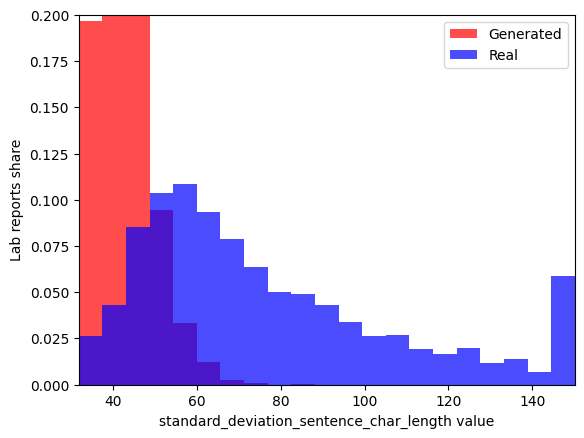

In [19]:
compare_2_hists('standard_deviation_sentence_char_length', top=0.2, one_hist=True)

In [14]:
from scipy.stats import percentileofscore
from api.api_models.lightbulb_score import LightbulbScoreType


def boost_with_cosine(score, boost=1.7, power=0.7):
    """
    Multiply by a smooth cosine bump centered at 0.
    - boost sets multiplier at 0.
    - power < 1 makes growth faster near 0.
    """
    s = float(np.clip(score, -1.0, 1.0))
    base = 0.5 * (1.0 + np.cos(np.pi * s))  # 1 at 0, 0 at ±1
    shaped = base ** power                  # adjust growth
    m = 1.0 + (boost - 1.0) * shaped
    return float(np.clip(s * m, -1.0, 1.0))

def _relative_percentile_score(value: float,real_values: np.ndarray,gen_values: np.ndarray, category: LightbulbScoreType):

    real_percentile = percentileofscore(real_values, value, kind="weak")/100.0
    real_median = np.median(real_values)
    gen_percentile = percentileofscore(gen_values, value, kind="weak")/100.0
    gen_median = np.median(gen_values)

    if category == LightbulbScoreType.HUMAN_WRITTEN:
        real_score = ((-abs(real_percentile - 0.5))*2)+1
        return boost_with_cosine(real_score)
    elif category == LightbulbScoreType.LLM_GENERATED:
        gen_score = (abs(gen_percentile - 0.5)-0.5)*2
        return boost_with_cosine(gen_score)
    else:
        real_score = real_percentile - 0.5
        gen_score = gen_percentile - 0.5
        result = real_score + gen_score
        if real_median < gen_median:
            result = -result

        return boost_with_cosine(result)

In [12]:
dao_attributes_to_compare: DAOAttributePL = DAOAttributePL('attributes', db_name="ananas_prod")
generated_to_compare2: AttributePLInDB = dao_attributes_to_compare.find_by_id("68914c3bd4d25aeed98fd629")

generated_flat_dict_to_compare2 = generated_to_compare2.to_flat_dict_normalized()

In [15]:
for feature in significant_features:
    feature_value = generated_flat_dict_to_compare2[feature]
    gen_values = [attribute[0][feature] for attribute in generated_flat_dict]
    real_values = [attribute[0][feature] for attribute in real_flat_dict]
    score = _relative_percentile_score(feature_value, real_values, gen_values, category=LightbulbScoreType.BIDIRECTIONAL)

    print(f"{feature} score: {score}")

stylometrix_metrics.grammatical_forms.G_PRO_REL score: 0.4131003402456816
combination_features.common_long_word_ratio score: -0.8837903724017637
stylometrix_metrics.grammatical_forms.G_ADP score: 0.0031771554460912396
combination_features.partial_attribute_statistics.perplexity_base.average score: 0.061477042687529744
combination_features.partial_attribute_statistics.perplexity_base_normalized.average score: 0.08430560700515817
combination_features.partial_attribute_statistics.perplexity.average score: 0.0930710723084079
stylometrix_metrics.inflection.IN_PRO_1NOM score: 0.44149116222232454
stylometrix_metrics.syntactic.SY_S_NOM score: 0.7731273031651433
stylometrix_metrics.lexical.L_CONT_A score: 0.18874073061994578
combination_features.common_rare_word_ratio score: 0.11624910821661796
stylometrix_metrics.lexical.L_TCCT1 score: 0.0999832795059513
perplexity_base score: 0.8448483014323735
stylometrix_metrics.lexical.L_CONT_T score: 0.676430846763499
combination_features.partial_attribut